<a href="https://www.kaggle.com/code/mehdiyeyldz/fish-classification-with-cnn?scriptVersionId=211064920" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import keras
import tensorflow as tf

from glob import glob
import random, os, datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import classification_report

from tensorflow.keras import layers, metrics
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models  import Sequential, load_model

from tensorflow.keras.metrics import Accuracy, AUC
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD


from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Images path'leri okumak ve image'leri görselleştirebilmek için gerekli fonksiyonlar:

In [2]:
def get_image_paths(root_dir, num_images=None):
    all_images = []
    for extension in ['*.jpg', '*.jpeg', '*.png']:
        all_images.extend(glob(os.path.join(root_dir, '**', extension), recursive=True))
    if num_images is None:
        return all_images
    else:
        return random.sample(all_images, min(num_images, len(all_images)))


def display_images(img_list):
    plt.figure(figsize=(15, 6))
    for i, img_path in enumerate(img_list):
        img = image.load_img(img_path)
        img = image.img_to_array(img, dtype=np.uint8)
        plt.subplot(2, 5, i + 1)
        plt.imshow(img.squeeze())
        plt.axis('off')
        plt.title(f'Image {i+1}')
    plt.tight_layout()
    plt.show()

Images dosyasının uzantısını okutalım.

In [3]:
dir_path = "/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset"

Her bir image'in path bilgisini yukarıda oluşturduğumuz get_image_paths fonksiyonunu kullanarak tek bir listede toplayalım.

In [4]:
img_paths = get_image_paths(dir_path)

Çeşitliliği gözlemleyebilmek için veriyi karıştıralım.

In [5]:
random.shuffle(img_paths)

In [6]:
len(img_paths)

18000

İlk 10 resmi inceleyelim.

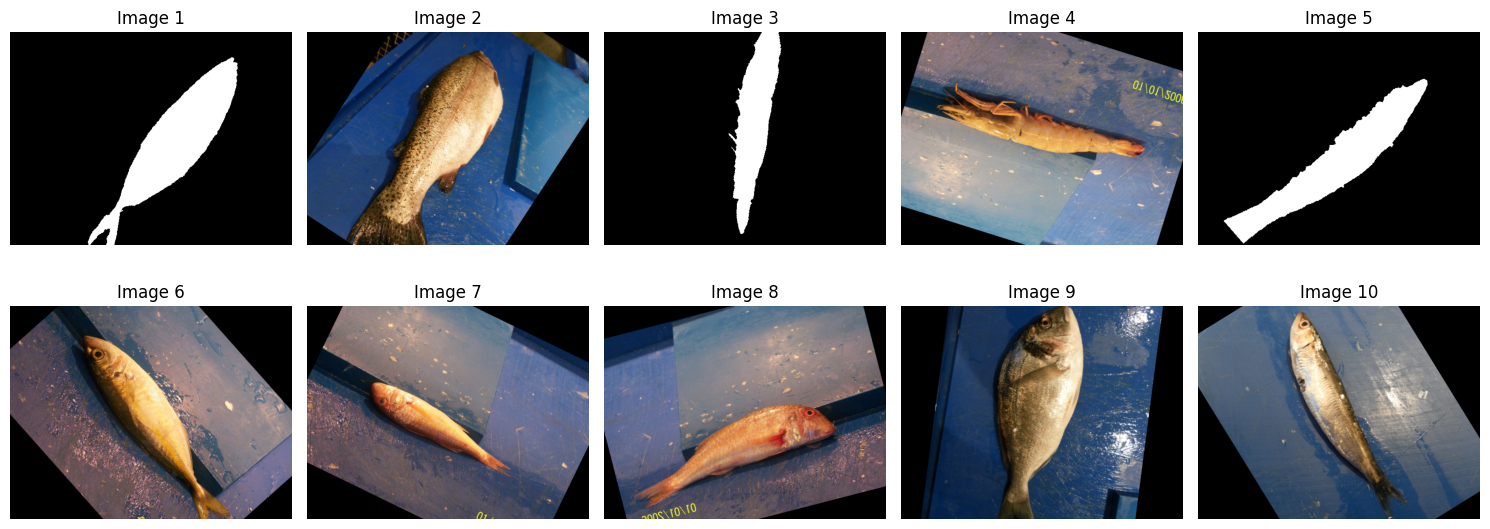

In [7]:
display_images(img_paths[0:10])

Görselleri train validasyon seti olarak ayırıp standartlaştıralım. Data augmentation uygulamadım. Çünkü dosyayı okurken GT(artırılmış veri) kısmını da almış oldum.
Buraya kadar izlediğimiz adımlar görselleri inceleyebilmek içindi. Burada ise ImageDataGenerator ile görselleri dizinden tekrar okutup almış olacağız.

In [8]:
train = ImageDataGenerator(validation_split=0.2,
                         rescale=1/255)

val = ImageDataGenerator(rescale=1/255,
                        validation_split=0.2)

Görüntüleri modellemeye uygun hale getirelim. class_mode=categorical ile target'ı encode hale dönüştürmüş oluyoruz. Homojen dağılımı sağlamak adına shuffle işlemi uygulayalım.

In [9]:
train_generator=train.flow_from_directory(dir_path,
                                          shuffle=True,
                                          target_size=(224, 224),
                                          batch_size=128,
                                          class_mode='categorical',
                                          subset='training')

validation_generator=val.flow_from_directory(dir_path,
                                             shuffle=True,
                                        target_size=(224, 224),
                                        batch_size=128,
                                        class_mode='categorical',
                                        subset='validation')

Found 14400 images belonging to 9 classes.
Found 3600 images belonging to 9 classes.


Bir batch içerisinde yer alan ilk 5 gözlemin labellarını inceleyelim. Encode edildiğini gözlemleyelim.

In [10]:
train_images, train_labels = next(train_generator)
print("First 5 labels from the training set:")
print(train_labels[:5])

First 5 labels from the training set:
[[0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]]


Model mimarisini oluşturalım.

In [11]:
model = Sequential([
    #özellik çıkarma(convolution)
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(64,(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128,(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Flatten(),
    
    #tam bağlantılı katmanlar
    BatchNormalization(),
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    layers.Dense(9, activation='softmax')
])


metrics = [
    "accuracy",
    AUC(name='auc', multi_label=True)]

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=metrics)


#optimizer=SGD(learning_rate=0.0001, momentum=0.9, nesterov=True) deneyebilirsin. nesterov=True ile öğrenme süreci daha hızlı, dikkatli ve aşırı zıplamalar olmadan ilerler.

In [12]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               verbose=1,
                               restore_best_weights=True, 
                               mode="min")

model_checkpoint = ModelCheckpoint(filepath='fish_model.keras',
                             monitor='val_loss',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1)

In [13]:
start_time = datetime.datetime.now()

history = model.fit(train_generator,
                    epochs=100,
                    validation_data=validation_generator,
                    callbacks=[early_stopping, model_checkpoint])

end_time = datetime.datetime.now()
total_duration = end_time - start_time
print("Trainin Time:", total_duration)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733253924.601788      84 service.cc:145] XLA service 0x7a0640002cb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733253924.601839      84 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733253924.601843      84 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1733253954.549033      84 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2368 - auc: 0.6591 - loss: 2.9805
Epoch 1: val_loss improved from inf to 2.86584, saving model to fish_model.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 295s 2s/step - accuracy: 0.2376 - auc: 0.6599 - loss: 2.9776 - val_accuracy: 0.2150 - val_auc: 0.8229 - val_loss: 2.8658
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 698ms/step - accuracy: 0.4939 - auc: 0.8751 - loss: 2.0842
Epoch 2: val_loss improved from 2.86584 to 2.85070, saving model to fish_model.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.4942 - auc: 0.8752 - loss: 2.0836 - val_accuracy: 0.1128 - val_auc: 0.8776 - val_loss: 2.8507
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.6381 - auc: 0.9355 - loss: 1.7199
Epoch 3: val_loss improved from 2.85070 to 2.79015, saving model to fish_model.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.6382 - auc: 0.9355 - loss: 1.7197 - val_accuracy: 0.1644 - val_auc: 0.9264 - val_loss: 2.7901
Epoch

Train ve validasyon setleri için verilen metrik ve loss değerlerini epoch'a göre görselleştirecek fonksiyon.

In [14]:
def plot_training_history(history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy'):

    #Loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_loss], label='Training Loss')
    plt.plot(history.history[val_loss], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Metrics
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_metric], label=f"Training: {train_metric}")
    plt.plot(history.history[val_metric], label=f"Validation: {val_metric}")
    plt.title(f'Training and Validation {train_metric} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(f'train_metric')
    plt.legend()
    plt.show()

Train ve validasyon setlerinin accuracy ve loss değerlerinin epoch'a göre grafigini çizdirelim.

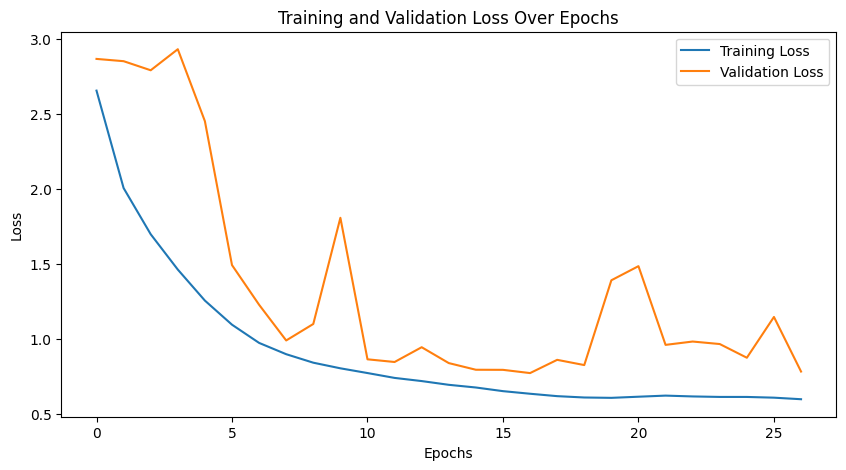

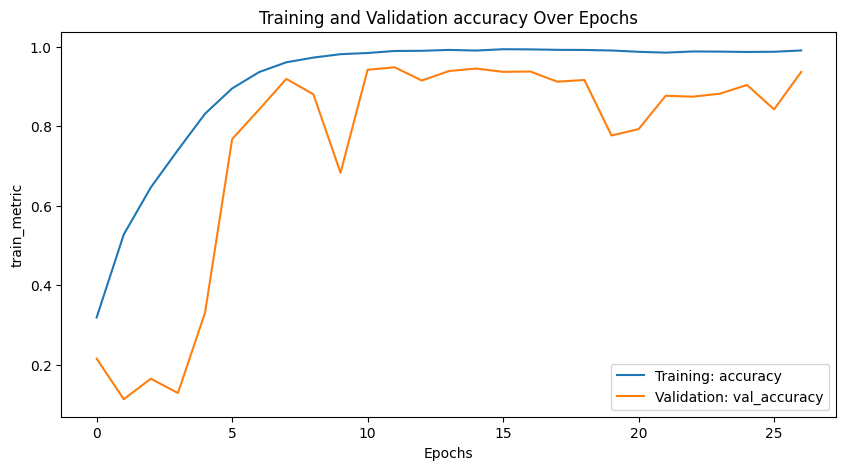

In [15]:
plot_training_history(history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy')

Metriklerin en iyi değerlerini inceleyelim.

In [16]:
val_loss, val_accuracy, val_auc = model.evaluate(validation_generator, verbose=0)
print(f"Loss: {val_loss}")
print(f"Accuracy: {val_accuracy}")
print(f"AUC: {val_auc}")

Loss: 0.771959662437439
Accuracy: 0.9377777576446533
AUC: 0.9964008331298828
